In [10]:
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax

# constructing the telescope:
wf_npixels = 256 # nice and low res
diameter = 0.125
period = 304e-6
difference = np.pi * 0.348

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 300
true_pixel_scale = 0.375
oversample = 4 # high level oversample

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,true_pixel_scale,oversample)

In [11]:
import pandas as pd
from scipy.stats import binned_statistic

# Step 1: Load from CSV
df = pd.read_csv("alpha_cen_A_spectrum.csv")  # replace with correct path if needed

# Step 2: Apply mask (wavelengths in Ångstroms, like original)
mask = (df["wavelength"] >= 5200) & (df["wavelength"] <= 6500)

# Step 3: Extract and convert to meters
wavelengths = df["wavelength"][mask].to_numpy() * 1e-10  # meters
weights = df["flux"][mask].to_numpy()

# Step 4: Downsample using binning
n_bins = 500
bin_means, bin_edges, _ = binned_statistic(
    wavelengths, weights, statistic='mean', bins=n_bins
)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Step 5: Create the point source
alpha_cen_a_source = dl.PointSource(
    wavelengths=bin_centers,
    weights=bin_means,
    flux=2.909*10**7 # from max charles code
)

In [12]:
alpha_cen_a_scope = dl.Telescope(optics,alpha_cen_a_source)

sidelobescope = dlT.SideLobeTelescope(alpha_cen_a_scope, period, difference)

In [13]:
import jax.random as jr # jax random
key = 0

In [14]:
center_wl = 585e-9
pixel_scale = 0.375
# make sure to downsample!, then apply jax random poisson noise!
sidelobes = jr.poisson(jr.PRNGKey(key), dlu.downsample(sidelobescope.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = pixel_scale),4,False) )

Model time: 23.7105 seconds.


In [15]:
# let's try recreating the figure but better this time:
# no need for poisson on the model
weights_path = 'telescope.source.spectrum.weights'

model = sidelobescope.set(weights_path, np.ones(n_bins)/n_bins)
#print(model)
model_psf = dlu.downsample(model.model_sidelobes(float(center_wl)),4,False)

# Optimisation
import zodiax as zdx
import optax

weights_optimiser = optax.adam(1e-4)

optim, opt_state = zdx.get_optimiser(model, weights_path, weights_optimiser)

out = dlu.downsample(model.model_sidelobes(float(center_wl)),4,False)

Model time: 26.5438 seconds.
Model time: 26.2340 seconds.


In [16]:
@zdx.filter_jit
@zdx.filter_value_and_grad(weights_path)
def loss_fn(model, data):
    out = dlu.downsample(model.model_sidelobes(center_wl),4,False)
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

In [17]:
%%time
loss, grads = loss_fn(model, sidelobes) # Compile
print("Initial Loss: {}".format(int(loss)))

Model time: 7.6081 seconds.
Initial Loss: 102230
CPU times: user 2min 21s, sys: 3.9 s, total: 2min 25s
Wall time: 58.5 s


In [18]:
from tqdm import tqdm

losses, models_out = [], []
with tqdm(range(100),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, sidelobes)    
        updates, opt_state = optim.update(grads, opt_state)
        #print(updates.source.weights[0])
        # prevent negative weights
        # Get current weights
        weights = model.get(weights_path)

        #print(weights[0])
        # # Get update for weights
        weight_updates = updates.get(weights_path)
        #print(weight_updates[0])
        # # Clamp the update: ensure weights + update >= 0
        epsilon = 1e-6
        safe_updates = np.where(weights + weight_updates < epsilon, epsilon-weights, weight_updates)
        #print(safe_updates[0])
        # # Create a copy of updates and replace the weights update with safe update
        updates = updates.set(weights_path, safe_updates)
        

        # Now apply
        model = zdx.apply_updates(model, updates)

        model = model.set(weights_path, np.maximum(np.zeros(n_bins),model.telescope.source.spectrum.weights))
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Log Loss: 4.790: 100%|██████████| 100/100 [23:41<00:00, 14.22s/it]


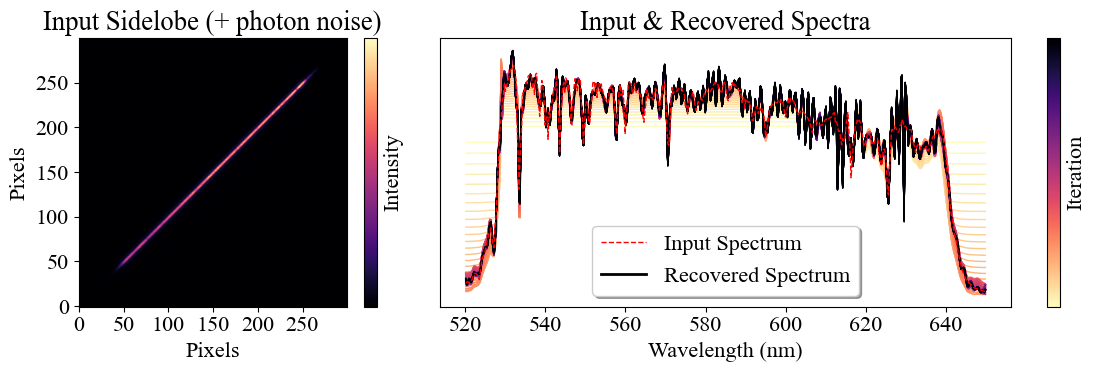

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Times New Roman font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

cmap = plt.get_cmap('magma')
norm = colors.Normalize(vmin=0, vmax=99)  # Normalize iteration range

# Create figure and gridspec
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1, 3, figure=fig)

# First subplot (column 1)
ax1 = fig.add_subplot(gs[0, 0])
im = ax1.imshow(sidelobes, origin='lower', cmap=cmap)
ax1.set_title('Input Sidelobe (+ photon noise)')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('Pixels')

tick_spacing = 50
image_shape = sidelobes.shape
ax1.set_xticks(np.arange(0, image_shape[1], tick_spacing))
ax1.set_yticks(np.arange(0, image_shape[0], tick_spacing))

cbar1 = fig.colorbar(im, ax=ax1)
cbar1.set_ticks([])  # remove tick marks and labels
cbar1.ax.set_ylabel('Intensity')

# Second subplot spans columns 2 and 3
ax2 = fig.add_subplot(gs[0, 1:3])

for i in range(100):
    output_weights = models_out[i].telescope.source.spectrum.weights / np.sum(models_out[i].telescope.source.spectrum.weights)
    color = cmap(1 - i / 99)
    ax2.plot(bin_centers * 1e9, output_weights, color=color, linewidth=1)

ax2.tick_params(axis='y', left=False, labelleft=False)
ax2.set_xlabel("Wavelength (nm)")
ax2.set_title("Input & Recovered Spectra")

# Overlay true spectrum
ax2.plot(bin_centers * 1e9, sidelobescope.telescope.source.spectrum.weights, color='red', linestyle='--', linewidth=1, label='Input Spectrum')
# Create a fake gradient entry using a Patch with the colormap
gradient_patch =  Line2D([0], [0], color='black', linestyle='-', label='Recovered Spectrum', linewidth=2)

# Existing legend items
input_line = Line2D([0], [0], color='red', linestyle='--', label='Input Spectrum', linewidth=1)

# Combine and add to legend
ax2.legend(handles=[input_line, gradient_patch], loc='lower center', shadow=True)
#ax2.legend(shadow=True,loc='lower center')
# Colorbar for iterations
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar2 = fig.colorbar(sm, ax=ax2, label="Iteration")
cbar2.ax.invert_yaxis()
cbar2.set_ticks([])

plt.tight_layout()
#plt.savefig('input_recovered_noisy.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [21]:
# saving stuff
import pickle

# Save sidelobes (original, not downsampled, or jax random)
# np.save("sidelobes_tol_noisy.npy", sidelobes)

# Save bin_centers (in meters, as in original code)
#np.save("bin_centers_tol_noisy.npy", bin_centers)

# Save input spectrum weights
#np.save("input_weights_tol.npy", sidelobescope.telescope.source.spectrum.weights)

# Save model outputs: 100 arrays of weights
output_weights_list = [model.telescope.source.spectrum.weights for model in models_out]
with open("output_weights_tol_noisy.pkl", "wb") as f:
    pickle.dump(output_weights_list, f)